# What is the most optimal skill to learn for Data Analysts?

#### Methodology

1. Continue from last notebook to find percent of postings with skill
2. Visualize median salary vs percent skill demand
3. (Optional) Determine if certain technologies are more prevalent

In [1]:
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

# Loading dataset
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset['train'].to_pandas()

# data cleanup
df['job_posted_date'] = pd.to_datetime(df.job_posted_date)
df['job_skills'] = df['job_skills'].apply(
    lambda skill_list: ast.literal_eval(skill_list) if pd.notna(skill_list) else skill_list)

## Clean Data

Filters the original dataset to only get rows where the job title is 'Data Analyst' and the country is 'United States', to create a new DataFrame `df_DA_US`. Drop NaN values from the 'salary_year_avg' column. Then it uses the `explode` method on the `job_skills` column to create a new row in a new DataFrame (`df_DA_US_exploded`) for each skill associated with a job. Finally, it displays the first 5 entries of the `salary_year_avg` and `job_skills` columns.

In [2]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') &
              (df['job_country'] == 'United States')].copy()

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel


## Calculate Percent of Job Postings that Have Skills

Group the data by job skills and calculates the count and median salary for each skill, sorting the results in descending order by count. It then renames the columns. Calculates the percentage that each skill count represents out of the total number of Data Analyst jobs. Finally, filter out any skills that don't have any jobs associated with them.

In [11]:
# using df_DA find the count of skills and also the median salary for each skill
df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(skill_count='size', median_salary='median').sort_values(by='skill_count', ascending=False)

DA_job_count = len(df_DA_US)  # Find count of Data Analyst jobs in US with salary info

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

df_DA_skills = df_DA_skills[df_DA_skills['skill_count'] > 0]

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.0,57.655172
excel,1808,84392.0,41.563218
python,1431,97500.0,32.896552
tableau,1364,92875.0,31.356322
sas,926,90000.0,21.287356
...,...,...,...
theano,1,100000.0,0.022989
typescript,1,65000.0,0.022989
vmware,1,147500.0,0.022989


## Median Salary vs Percent Skill Demand

Filters for Data Analyst skills that exceed a certain percentage (`skill_limit`).

In [9]:
skill_limit = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]
df_DA_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


Create a scatter plot to visualize the relationship between the percentage of Data Analyst jobs that require specific skills and the median salary for those skills.

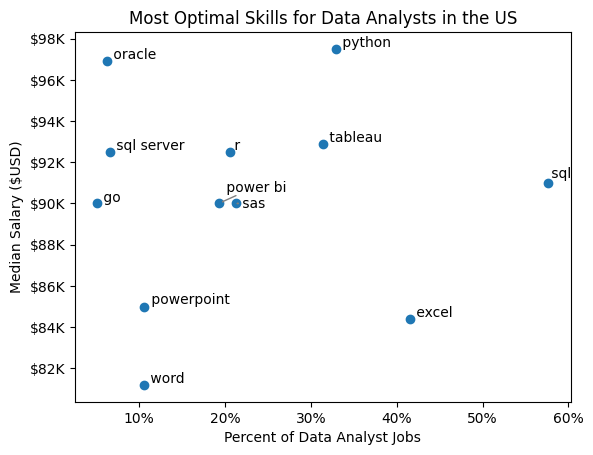

In [14]:
from adjustText import adjust_text

plt.scatter(df_DA_skills_high_demand['skill_percent'],
            df_DA_skills_high_demand['median_salary'])
plt.xlabel('Percent of Data Analyst Jobs')
# Assuming this is the label you want for y-axis
plt.ylabel('Median Salary ($USD)')
plt.title('Most Optimal Skills for Data Analysts in the US')

from matplotlib.ticker import PercentFormatter
# Get current axes, set limits, and format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))  # Example formatting y-axis
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Add labels to points and collect them in a list
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i],
                 df_DA_skills_high_demand['median_salary'].iloc[i], " " + txt))

# Adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

### Coloring by Technology

Add color labels based on technology.

Removes duplicate entries and any rows with missing values. Then, it combines all dictionary entries into a single dictionary, summing values for keys that repeat across entries. To ensure each key's values are unique, it converts the values to a set and then back to a list. The final result is a dictionary where each key represents a skill and each value is a list of unique attributes associated with that skill.

In [20]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

{'analyst_tools': ['alteryx',
  'nuix',
  'qlik',
  'dax',
  'ssis',
  'spreadsheet',
  'spss',
  'powerbi',
  'powerpoint',
  'microstrategy',
  'splunk',
  'cognos',
  'sharepoint',
  'ms access',
  'esquisse',
  'datarobot',
  'msaccess',
  'tableau',
  'power bi',
  'looker',
  'outlook',
  'visio',
  'sheets',
  'ssrs',
  'excel',
  'word',
  'sap',
  'sas'],
 'programming': ['groovy',
  'c#',
  'cobol',
  'rust',
  'shell',
  'sass',
  'ruby',
  'go',
  'c++',
  'dart',
  'powershell',
  'javascript',
  'lua',
  'swift',
  'sql',
  'erlang',
  'objective-c',
  'nosql',
  'html',
  'julia',
  'bash',
  'typescript',
  'visualbasic',
  'haskell',
  'php',
  'vba',
  'mongodb',
  'vb.net',
  'c',
  'ocaml',
  'solidity',
  'fortran',
  'assembly',
  'visual basic',
  'kotlin',
  'f#',
  'mongo',
  'apl',
  'java',
  'crystal',
  'clojure',
  'pascal',
  'perl',
  'golang',
  't-sql',
  'python',
  'matlab',
  'no-sql',
  'css',
  'delphi',
  'scala',
  'elixir',
  'sas',
  'r',
  'l

This code converts a dictionary into a pandas DataFrame, then explodes the 'skills' column, creating multiple rows for each 'technology' entry if it contains multiple skills.

In [21]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=[
                             'technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,alteryx
0,analyst_tools,nuix
0,analyst_tools,qlik
0,analyst_tools,dax
0,analyst_tools,ssis
...,...,...
9,sync,twilio
9,sync,slack
9,sync,webex
9,sync,unify


Merges two DataFrames, `df_DA_skills` and `df_technology`, based on the columns 'job_skills' and 'skills' respectively, creating a new DataFrame `df_DA_skills_tech`.

In [22]:
# merge df_DA_skills and df_technology
df_DA_skills_tech = df_DA_skills.merge(
    df_technology, left_on='job_skills', right_on='skills')

df_DA_skills_tech

,skill_count,median_salary,skill_percent,technology,skills
0,2508,91000.0,57.655172,programming,sql
1,1808,84392.0,41.563218,analyst_tools,excel
2,1431,97500.0,32.896552,programming,python
3,1364,92875.0,31.356322,analyst_tools,tableau
4,926,90000.0,21.287356,analyst_tools,sas
...,...,...,...,...,...
169,1,100000.0,0.022989,libraries,theano
170,1,65000.0,0.022989,programming,typescript
171,1,147500.0,0.022989,cloud,vmware
172,1,65000.0,0.022989,webframeworks,vue


Filters `df_DA_skills_tech` to select rows where the 'percent' column exceeds a specified threshold, storing the result in `df_DA_skills_tech_high_demand`. 

In [23]:
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_limit]

Plot the results in a scatter plot, coloring the points based on the 'technology' column.

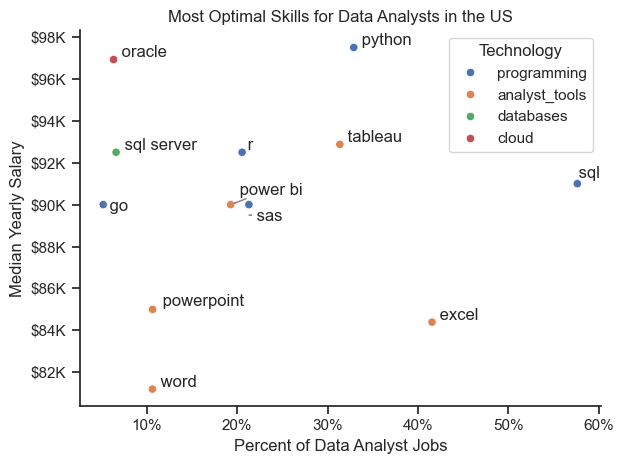

In [37]:
from matplotlib.ticker import PercentFormatter
sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    if txt == 'powerbi':  # Manually adjust 'powerbi' position
        texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i],  # Larger shift right
                              df_DA_skills_high_demand['median_salary'].iloc[i] + 500,  # Shift downwards
                              " " + txt))
    elif txt == 'sas':  # Manually adjust 'sas' position
        texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i],  # Shift left
                              df_DA_skills_high_demand['median_salary'].iloc[i] - 500,  # Shift upwards
                              " " + txt))
    else:
        # Default label position for others
        texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i],
                              df_DA_skills_high_demand['median_salary'].iloc[i],
                              " " + txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.legend(title='Technology')

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot
plt.tight_layout()
plt.show()